# Projet 4: [Analysez les ventes de votre entreprise](#M0)

# Table des matières
**[I. Nettoyage des données](#M1)**
- [1. Table "clients"](#M11)    
- [2. Table "produits"](#M12)
- [3. Table "ventes"](#M13)
- [4. Jointures](#M14)
    
**[II. Analyses réalisées](#M2)**
- [1. Que sait-on des clients?](#M21)
    - [a) Composition hommes/femmes](#M211)
    - [b) Quel est l'âge de la clientèle?](#M212)            
- [2. Que vend l'entreprise?](#M22)
    - [a) Catégorie des produits proposés](#M221)
    - [b) Quels sont les prix des produits proposés?](#M222)     
        - [Comparaison globale](#M2221)                     
- [3. Résultats bruts des ventes](#M23)
    - [a) Quels produits ont été vendus?](#M231)        
        - [Volume d'achats de chaque produit](#M2311)
            - [Podium des 10 livres de chaque catégorie les plus vendus](#M23111)
            - [Evolution du montant des ventes en fonction du volume de produits proposés](#M23112)
        - [Détail du volume des ventes par mois](#M2312)  
            - [Recherche d'explications concernant la baisse soudaine d'octobre de la catégorie 1](#M23121)
        - [Détail du chiffre d'affaire par mois](#M2313)                   
        - [Comparaison chiffre d'affaire et volume des ventes](#M2314)        
    - [b) Composition du panier des clients](#M232)    
        - [Paniers revendeurs et paniers clients lambda](#M2321)
        - [Comparaison montant et nombre d'articles des paniers clients lambda](#M2322)
- [4. Sexe des clients et catégories de produits achetés](#M24)
    - [Analyse](#M241)
    - [Corrélation (variables qualitatives)](#M242)
- [5. Age des clients...](#M25)
    - [a) ... et montant total des achats](#M251)
        - [Analyse](#M2511)
        - [Corrélation (variable qualitative et quantitative)](#M2512)
    - [b) ... et fréquence d'achat par mois](#M252)
        - [Analyse](#M2521)
        - [Corrélation (variable qualitative et quantitative)](#M2522)
    - [c) ... et taille du panier moyen en nombre d'articles](#M253)
        - [Analyse](#M2531)
        - [Corrélation (variable qualitative et quantitative)](#M2532)
    - [d) ... et catégories de produits achetés](#M254)
        - [Analyse](#M2541)
        - [Corrélation (variables qualitative et quantitative)](#M2542)

In [1]:
import pandas as pd
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn import linear_model

In [2]:
plt.rcParams['font.size'] = 15

# I. Nettoyage des données.<a name="M1"></a>
## <span style='color:orange'>1.Table "clients"<a name="M11"></a>

In [3]:
clients = pd.read_csv('customers.csv')
clients.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [4]:
clients.shape # Dimensions de la table

(8623, 3)

In [5]:
# Nombre de valeurs manquantes détectées par colonne:
for col in clients.columns:
    print('"%s": %i' %(col, clients[col].isnull().sum()))   

"client_id": 0
"sex": 0
"birth": 0


In [6]:
# Nombre de doublons:
clients.duplicated().sum()

0

In [7]:
def analyse_id_clients(identifiant):
    if re.match(r'^c\_(\d+)$', str(identifiant)) is None:
        print(clients.loc[clients.client_id == identifiant])
        print()
        print('"{0}" n\'est pas au bon format.'.format(identifiant))
        print()
    else:
        return identifiant

In [8]:
clients.client_id = clients.client_id.apply(analyse_id_clients)

     client_id sex  birth
2735      ct_0   f   2001

"ct_0" n'est pas au bon format.

     client_id sex  birth
8494      ct_1   m   2001

"ct_1" n'est pas au bon format.



In [9]:
# Suppression de ct_0 et ct_1:
clients.drop([2735, 8494], inplace = True)

In [10]:
clients.loc[2734:2736]

,client_id,sex,birth
2734,c_4406,f,1998
2736,c_3195,m,2004


In [11]:
clients.loc[8493:8495]

,client_id,sex,birth
8493,c_3128,f,1969
8495,c_1218,m,1976


In [12]:
def analyse_birth(annee):
    if re.match('^(19[2-9]\d|20[01]\d)$', str(annee)) is None:
        print(clients.loc[clients.birth == annee])
        print()
        print('"{0}" n\'est pas reconnue.'.format(annee))
        print()
    else:
        return annee

In [13]:
clients.birth = clients.birth.apply(analyse_birth)  # RAS

In [14]:
# Création d'une colonne "âge", plus simple à manipuler que l'année de naissance:
clients['age'] = clients['birth'].apply(lambda x: 2022 - x)
clients.describe().apply(np.int64)

,birth,age
count,8621,8621
mean,1978,43
std,16,16
min,1929,18
25%,1966,30
50%,1979,43
75%,1992,56
max,2004,93


In [15]:
# pour avoir une sauvegarde de "clients" sans modifications:
clients_ok = clients.copy()

##  <span style='color:orange'>2. Table "produits"<a name="M12"></a>

In [16]:
produits = pd.read_csv('products.csv')
produits.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [17]:
produits.shape

(3287, 3)

In [18]:
# Nombre de valeurs manquantes détectées par colonne:
for col in produits.columns:
    print('"%s": %i' %(col, produits[col].isnull().sum()))   

"id_prod": 0
"price": 0
"categ": 0


In [19]:
# Nombre de doublons:
produits.duplicated().sum()

0

In [20]:
def analyse_id_produits(identifiant):
    if re.match(r'^[012]\_(\d+)$', str(identifiant)) is None:
        print(produits.loc[produits.id_prod == identifiant])
        print()
        print('"{0}" n\'est pas au bon format.'.format(identifiant))
        print()
    else:
        return identifiant

In [21]:
produits.id_prod = produits.id_prod.apply(analyse_id_produits)

    id_prod  price  categ
731     T_0   -1.0      0

"T_0" n'est pas au bon format.



In [22]:
produits.drop(731, inplace = True)
produits.loc[730:732]

,id_prod,price,categ
730,0_219,13.99,0
732,0_407,15.99,0


In [23]:
def analyse_price(prix):
    if re.match(r'^(\d+)\.(\d+)$', str(prix)) is None:
        print(produits.loc[produits.price == prix])
        print()
        print('"{0}" n\'est pas reconnue. Il sera ignoré.'.format(prix))
        return np.NaN
    else:
        return prix

In [24]:
produits.price = produits.price.apply(analyse_price) # RAS

In [25]:
# Création d'une fonction qui vérifie la concordance de l'identifiant-produit avec son numéro de catégorie:
def lien_id_produits_categ(identifiant, numero):
    difference = int(identifiant[0]) - numero
    if difference != 0:
        local = produits.loc[produits.id_prod == identifiant]
        if local.index.notnull().any():
            print(local)
            print()
            proposition = str(input('"{0}" n\'est pas conforme. Corriger (c)? Réponse (o/n): '.format(identifiant)))
            print()
            trigger = True
            while proposition not in ['o', 'n']:
                proposition = str(input('"{0}" n\'est pas conforme. Corriger (c)? Réponse (o/n): '.format(identifiant)))
                print()
            if proposition == 'o':
                trigger = False
                correction = str(numero)+identifiant[1:]
                print('Corrigé!')
                print()
                return correction
            elif proposition == 'n':
                return identifiant
    else:
        return identifiant

In [26]:
produits.id_prod = [lien_id_produits_categ(x, y) for x, y in zip(produits.id_prod, produits.categ)] # RAS

In [27]:
produits.shape

(3286, 3)

In [28]:
produits_ok = produits.copy() # Sauvegarde

##  <span style='color:orange'>3. Table "ventes"<a name="M13"></a>

In [29]:
ventes = pd.read_csv('transactions.csv')
ventes.head()

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242


In [30]:
ventes.shape

(337016, 4)

In [31]:
# Nombre de valeurs manquantes détectées par colonne:
for col in ventes.columns:
    print('"%s": %i' %(col, ventes[col].isnull().sum()))

"id_prod": 0
"date": 0
"session_id": 0
"client_id": 0


In [32]:
# Nombre de doublons:
ventes.duplicated().sum()

126

In [33]:
# On affiche les doublons:
ventes[ventes.duplicated(keep = 'last')]

,id_prod,date,session_id,client_id
1431,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1
2895,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1
5955,T_0,test_2021-03-01 02:30:02.237441,s_0,ct_0
7283,T_0,test_2021-03-01 02:30:02.237434,s_0,ct_1
13745,T_0,test_2021-03-01 02:30:02.237443,s_0,ct_0
20470,T_0,test_2021-03-01 02:30:02.237442,s_0,ct_0
22347,T_0,test_2021-03-01 02:30:02.237412,s_0,ct_1
26359,T_0,test_2021-03-01 02:30:02.237439,s_0,ct_1
26407,T_0,test_2021-03-01 02:30:02.237426,s_0,ct_0
26814,T_0,test_2021-03-01 02:30:02.237447,s_0,ct_1


In [34]:
# Suppression des doublons:
ventes.drop_duplicates(inplace = True)
ventes.shape

(336890, 4)

In [35]:
def analyse_prod_ventes(produit):
    if re.match(r'^[012]\_(\d+)$', str(produit)) is None:
        local = ventes.loc[ventes.id_prod == produit]
        if local.index.notnull().any():
            print(local)
            print()
            print('"{0}" n\'est pas au bon format. Il sera supprimé.'.format(produit))
            print()
            ventes.drop(local.index, inplace = True)
            print('Supprimé!')
            print()
    else:
        return produit

In [36]:
ventes.id_prod = ventes.id_prod.apply(analyse_prod_ventes)

       id_prod                             date session_id client_id
1431       T_0  test_2021-03-01 02:30:02.237420        s_0      ct_1
2365       T_0  test_2021-03-01 02:30:02.237446        s_0      ct_1
2895       T_0  test_2021-03-01 02:30:02.237414        s_0      ct_1
5955       T_0  test_2021-03-01 02:30:02.237441        s_0      ct_0
7283       T_0  test_2021-03-01 02:30:02.237434        s_0      ct_1
13745      T_0  test_2021-03-01 02:30:02.237443        s_0      ct_0
20470      T_0  test_2021-03-01 02:30:02.237442        s_0      ct_0
22347      T_0  test_2021-03-01 02:30:02.237412        s_0      ct_1
26359      T_0  test_2021-03-01 02:30:02.237439        s_0      ct_1
26407      T_0  test_2021-03-01 02:30:02.237426        s_0      ct_0
26814      T_0  test_2021-03-01 02:30:02.237447        s_0      ct_1
27161      T_0  test_2021-03-01 02:30:02.237434        s_0      ct_0
32675      T_0  test_2021-03-01 02:30:02.237438        s_0      ct_0
36700      T_0  test_2021-03-01 02

In [37]:
ventes.shape

(336816, 4)

In [38]:
def analyse_date(temps):
    if re.match(r'^((202[12])\-(0[1-9]|1[012])\-(0[1-9]|[12]\d|3[01])) (([01]\d|2[0-3])\:([0-5]\d)\:([0-5]\d)\.(\d{6}))$', str(temps)) is None:
        print(ventes.loc[ventes.date == temps])
        print()
        print('"{0}" n\'est pas au bon format.'.format(temps))
        print()
    else:
        return temps

In [39]:
ventes.date = ventes.date.apply(analyse_date) # RAS

In [40]:
def analyse_session_ventes(session):
    if re.match(r'^s\_(\d+)$', str(session)) is None:
        print(ventes.loc[ventes.session_id == session])
        print()
        print('"{0}" n\'est pas au bon format.'.format(session))
        print()
    else:
        return session

In [41]:
ventes.session_id = ventes.session_id.apply(analyse_session_ventes) # RAS

In [42]:
def analyse_clients_ventes(identifiant):
    if re.match(r'^c\_(\d+)$', str(identifiant)) is None:
        print(ventes.loc[ventes.client_id == identifiant])
        print()
        print('"{0}" n\'est pas au bon format.'.format(identifiant))
        print()
    else:
        return identifiant

In [43]:
ventes.client_id = ventes.client_id.apply(analyse_clients_ventes) # RAS

In [44]:
ventes.shape

(336816, 4)

In [45]:
ventes_ok = ventes.copy() # Sauvegarde

##  <span style='color:orange'>4. Jointures<a name="M14"></a>

In [46]:
# On joint les tables ventes_ok et produits_ok:
# ("indicator", en paramètre, permet de savoir si un élément est commun ou non aux deux tables grâce à la colonne "_merge")
recoupe = pd.merge(ventes_ok, produits_ok, on = 'id_prod', how = 'outer', indicator = True)
recoupe.head()

,id_prod,date,session_id,client_id,price,categ,_merge
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0.0,both
1,0_1483,2021-10-18 19:16:14.767807,s_106741,c_1576,4.99,0.0,both
2,0_1483,2021-11-14 11:11:45.276771,s_119491,c_182,4.99,0.0,both
3,0_1483,2021-07-30 19:37:16.087057,s_69222,c_1196,4.99,0.0,both
4,0_1483,2021-03-30 14:18:13.403218,s_13545,c_2890,4.99,0.0,both


In [47]:
recoupe.shape

(336838, 7)

In [48]:
# Décommpte des valeurs non communes aux deux tables:
recoupe.isna().sum()

id_prod         0
date           22
session_id     22
client_id      22
price         103
categ         103
_merge          0
dtype: int64

In [49]:
produits_invendus = recoupe[recoupe._merge == 'right_only']
produits_invendus

,id_prod,date,session_id,client_id,price,categ,_merge
336816,0_1016,NaN,NaN,NaN,35.06,0.0,right_only
336817,0_1780,NaN,NaN,NaN,1.67,0.0,right_only
336818,0_1062,NaN,NaN,NaN,20.08,0.0,right_only
336819,0_1119,NaN,NaN,NaN,2.99,0.0,right_only
336820,0_1014,NaN,NaN,NaN,1.15,0.0,right_only
336821,1_0,NaN,NaN,NaN,31.82,1.0,right_only
336822,0_1318,NaN,NaN,NaN,20.92,0.0,right_only
336823,0_1800,NaN,NaN,NaN,22.05,0.0,right_only
336824,0_1645,NaN,NaN,NaN,2.99,0.0,right_only
336825,0_322,NaN,NaN,NaN,2.99,0.0,right_only


In [50]:
produits_invendus.shape[0]

22

In [51]:
proportion_invendus = produits_invendus.shape[0]/produits_ok.shape[0]*100
proportion_invendus

0.6695069993913573

On constate ces 22 produits invendus, qu'on va supprimer de la table recoupe (ils représentent moins de 1% des produits à vendre).<br/>
Le choix est fait en revanche de les conserver dans la table produits_ok car ils ont pu ou pourront être vendu hors la période étudiée.

In [52]:
recoupe.drop(produits_invendus.index, 0, inplace = True)

In [53]:
recoupe.shape # ok

(336816, 7)

In [54]:
produits_imp = recoupe[recoupe._merge == 'left_only']
produits_imp

,id_prod,date,session_id,client_id,price,categ,_merge
307791,0_2245,2021-06-17 03:03:12.668129,s_49705,c_1533,NaN,NaN,left_only
307792,0_2245,2021-06-16 05:53:01.627491,s_49323,c_7954,NaN,NaN,left_only
307793,0_2245,2021-11-24 17:35:59.911427,s_124474,c_5120,NaN,NaN,left_only
307794,0_2245,2022-02-28 18:08:49.875709,s_172304,c_4964,NaN,NaN,left_only
307795,0_2245,2021-03-01 00:09:29.301897,s_3,c_580,NaN,NaN,left_only
307796,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098,NaN,NaN,left_only
307797,0_2245,2021-10-19 00:28:01.920054,s_106841,c_3953,NaN,NaN,left_only
307798,0_2245,2022-02-25 00:08:08.736068,s_170426,c_6236,NaN,NaN,left_only
307799,0_2245,2021-08-22 08:51:27.564509,s_79102,c_6752,NaN,NaN,left_only
307800,0_2245,2021-05-12 03:36:34.586221,s_33316,c_6205,NaN,NaN,left_only


On constate que le produit "0_2245" n'a pas de prix et pas de categorie malgré les sessions_clients.<br/>
On va lui assigner la catégorie 0 (son identifiant commence par 0) et lui imputer un prix par la médiane des prix de la catégorie 0.<br/>
(le choix de supprimer ces lignes est écarté car ce produit a été vendu plus de 100 fois).
<br/>Il faudra le signaler au client afin qu'il rectifie cet oubli.

Il faudra également le rajouter à la table produits_ok car il n'est logiquement pas référencé, comme on le voit ci-dessous:

In [55]:
produits_ok.loc[produits_ok.id_prod == '0_2245']

,id_prod,price,categ


In [56]:
# Imputation par la valeur 0 dans "categ":
recoupe.categ.replace(np.NaN, '0', inplace = True)
recoupe.iloc[produits_imp.index].head()

,id_prod,date,session_id,client_id,price,categ,_merge
307791,0_2245,2021-06-17 03:03:12.668129,s_49705,c_1533,NaN,0,left_only
307792,0_2245,2021-06-16 05:53:01.627491,s_49323,c_7954,NaN,0,left_only
307793,0_2245,2021-11-24 17:35:59.911427,s_124474,c_5120,NaN,0,left_only
307794,0_2245,2022-02-28 18:08:49.875709,s_172304,c_4964,NaN,0,left_only
307795,0_2245,2021-03-01 00:09:29.301897,s_3,c_580,NaN,0,left_only


In [57]:
# Imputation par la médiane des prix de la catégorie 0 dans "price":
round(produits_ok[produits_ok.categ==0].price.median(), 2)

10.32

In [58]:
recoupe.price.replace(np.NaN, '10.32', inplace = True)
recoupe.iloc[produits_imp.index].head()

,id_prod,date,session_id,client_id,price,categ,_merge
307791,0_2245,2021-06-17 03:03:12.668129,s_49705,c_1533,10.32,0,left_only
307792,0_2245,2021-06-16 05:53:01.627491,s_49323,c_7954,10.32,0,left_only
307793,0_2245,2021-11-24 17:35:59.911427,s_124474,c_5120,10.32,0,left_only
307794,0_2245,2022-02-28 18:08:49.875709,s_172304,c_4964,10.32,0,left_only
307795,0_2245,2021-03-01 00:09:29.301897,s_3,c_580,10.32,0,left_only


In [59]:
recoupe.isna().sum() # vérification

id_prod       0
date          0
session_id    0
client_id     0
price         0
categ         0
_merge        0
dtype: int64

In [60]:
# Pour obtenir des entiers dans categ à la place des nombres "float":
recoupe.categ = recoupe.categ.apply(np.int64)
# Afin de se servir à nouveau du paramètre "indicator" par la suite:
recoupe.drop(['_merge'], 1, inplace = True)
recoupe.head()

,id_prod,date,session_id,client_id,price,categ
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0
1,0_1483,2021-10-18 19:16:14.767807,s_106741,c_1576,4.99,0
2,0_1483,2021-11-14 11:11:45.276771,s_119491,c_182,4.99,0
3,0_1483,2021-07-30 19:37:16.087057,s_69222,c_1196,4.99,0
4,0_1483,2021-03-30 14:18:13.403218,s_13545,c_2890,4.99,0


In [61]:
produits_ok.loc[3287] = {'id_prod': '0_2245', 'price': '10.32', 'categ': '0'}
produits_ok.tail() # Le produit "0_2245" est bien rajoutée dans la table "produits_ok".

,id_prod,price,categ
3283,0_146,17.14,0
3284,0_802,11.22,0
3285,1_140,38.56,1
3286,0_1920,25.16,0
3287,0_2245,10.32,0


In [62]:
# On continue l'association de la table recoupe avec la table client_ok:
activite = pd.merge(recoupe, clients_ok, on = 'client_id', how = 'outer', indicator = True)
activite.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,_merge
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0.0,f,1977,45,both
1,0_1085,2021-09-29 11:14:59.793823,s_97382,c_4450,3.99,0.0,f,1977,45,both
2,0_1453,2021-08-27 19:50:46.796939,s_81509,c_4450,7.99,0.0,f,1977,45,both
3,0_1405,2021-08-27 20:07:25.878440,s_81509,c_4450,4.99,0.0,f,1977,45,both
4,0_1392,2021-12-28 11:45:04.072281,s_141302,c_4450,6.3,0.0,f,1977,45,both


In [63]:
activite.shape

(336837, 10)

In [64]:
activite.isna().sum() 

id_prod       21
date          21
session_id    21
client_id      0
price         21
categ         21
sex            0
birth          0
age            0
_merge         0
dtype: int64

In [65]:
clients_non = activite[activite._merge == 'right_only']
clients_non

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,_merge
336816,NaN,NaN,NaN,c_8253,NaN,NaN,f,2001,21,right_only
336817,NaN,NaN,NaN,c_3789,NaN,NaN,f,1997,25,right_only
336818,NaN,NaN,NaN,c_4406,NaN,NaN,f,1998,24,right_only
336819,NaN,NaN,NaN,c_2706,NaN,NaN,f,1967,55,right_only
336820,NaN,NaN,NaN,c_3443,NaN,NaN,m,1959,63,right_only
336821,NaN,NaN,NaN,c_4447,NaN,NaN,m,1956,66,right_only
336822,NaN,NaN,NaN,c_3017,NaN,NaN,f,1992,30,right_only
336823,NaN,NaN,NaN,c_4086,NaN,NaN,f,1992,30,right_only
336824,NaN,NaN,NaN,c_6930,NaN,NaN,m,2004,18,right_only
336825,NaN,NaN,NaN,c_4358,NaN,NaN,m,1999,23,right_only


In [66]:
clients_non.shape[0]

21

In [67]:
proportion_clients_non = clients_non.shape[0]/clients_ok.shape[0]*100
proportion_clients_non

0.24359123071569425

Il y a donc 21 clients qui n'ont pas consommé sur cette période, ce qui représente moins de 0.3% des clients.<br/>
On les retire de la table activite.

In [68]:
activite.drop(clients_non.index, 0, inplace = True)
activite.shape

(336816, 10)

In [69]:
activite[activite._merge == 'left_only']

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,_merge


Tous les clients qui ont effectué un achat sont bien référencés dans la table clients_ok.

In [70]:
# Pour obtenir des entiers dans categ à la place des nombres "float":
activite.categ = activite.categ.apply(np.int64)
activite.drop('_merge', 1, inplace = True)

In [71]:
#création de colonnes temporelles distinctes en découpant la colonne "date": 
activite['annee-mois'] = activite['date'].apply(lambda x: x[:7])
activite['jour'] = activite['date'].apply(lambda x: x[8:10])
activite['heure-min'] = activite['date'].apply(lambda x: x[11:16])
# On réorganise l'ordre des colonnes:
activite = activite.reindex(columns = ['session_id', 'annee-mois', 'jour', 'heure-min', 'id_prod', 'price', 'categ', 'client_id', 'sex', 'age', 'birth', 'date'])
# Tri par "date":
activite.sort_values(['date'], ascending = True, inplace = True)
activite.head()

,session_id,annee-mois,jour,heure-min,id_prod,price,categ,client_id,sex,age,birth,date
272113,s_1,2021-03,01,00:01,0_1259,11.99,0,c_329,f,55,1967,2021-03-01 00:01:07.843138
217524,s_2,2021-03,01,00:02,0_1390,19.37,0,c_664,m,62,1960,2021-03-01 00:02:26.047414
153790,s_3,2021-03,01,00:02,0_1352,4.5,0,c_580,m,34,1988,2021-03-01 00:02:38.311413
174440,s_4,2021-03,01,00:04,0_1458,6.55,0,c_7912,f,33,1989,2021-03-01 00:04:54.559692
284518,s_5,2021-03,01,00:05,0_1358,16.49,0,c_2033,f,66,1956,2021-03-01 00:05:18.801198


In [72]:
activite.drop(['date'], 1, inplace = True)
activite.head()

,session_id,annee-mois,jour,heure-min,id_prod,price,categ,client_id,sex,age,birth
272113,s_1,2021-03,01,00:01,0_1259,11.99,0,c_329,f,55,1967
217524,s_2,2021-03,01,00:02,0_1390,19.37,0,c_664,m,62,1960
153790,s_3,2021-03,01,00:02,0_1352,4.5,0,c_580,m,34,1988
174440,s_4,2021-03,01,00:04,0_1458,6.55,0,c_7912,f,33,1989
284518,s_5,2021-03,01,00:05,0_1358,16.49,0,c_2033,f,66,1956


In [73]:
activites = activite.copy()

# II. Analyses réalisées.<a name="M2"></a>

## <span style='color:orange'>1. Que sait-on des clients?<a name="M21"></a>

### <span style='color:purple'>a) Composition hommes/femmes.<a name="M211"></a>

In [74]:
proportion_femmes = clients_ok['sex'].value_counts()[0]/(clients_ok['sex'].count())*100
proportion_hommes = 100 - proportion_femmes

In [75]:
clients_non['sex'].value_counts()

f    11
m    10
Name: sex, dtype: int64

In [76]:
proportion_acheteuses = (clients_ok['sex'].value_counts()[0]-clients_non['sex'].value_counts()[0])/clients_ok.sex.count()*100
proportion_acheteurs = 100 - proportion_acheteuses

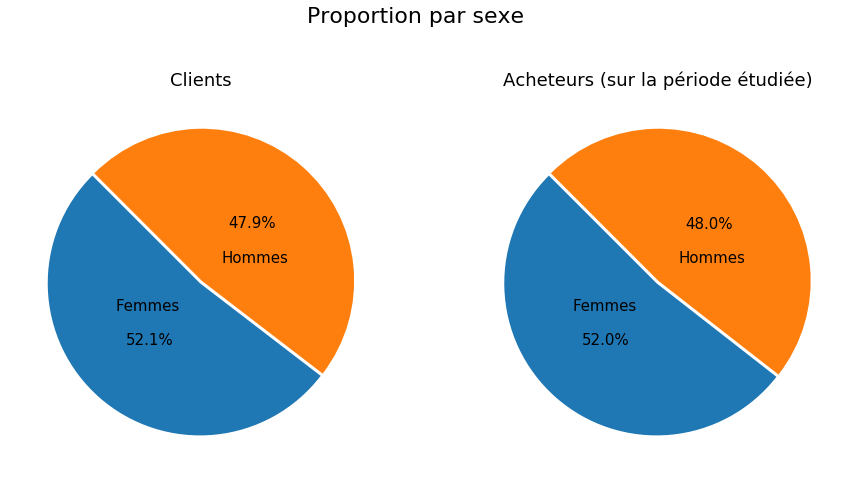

In [77]:
plt.figure(figsize = (15, 8))

plt.subplot(1, 2, 1)
plt.pie([proportion_femmes, proportion_hommes],
        labels = ['Femmes', 'Hommes'],
        autopct = '%1.1f%%',
        explode = (0.01, 0.01),
        pctdistance = 0.5,
        labeldistance = 0.2,
        startangle = 135)
plt.title('Clients',
          size = 18)

plt.subplot(1, 2, 2)
plt.pie([proportion_acheteuses, proportion_acheteurs],
        labels = ['Femmes', 'Hommes'],
        autopct = '%1.1f%%',
        explode = (0.01, 0.01),
        pctdistance = 0.5,
        labeldistance = 0.2,
        startangle = 135)
plt.title('Acheteurs (sur la période étudiée)',
          size = 18)

plt.suptitle('Proportion par sexe', size = 22);

### <span style='color:purple'>b) Quel est l'âge de la clientèle?<a name="M212"></a>

In [78]:
clients_ok.age = clients_ok.age.apply(np.int64)

In [79]:
femmes = clients_ok.loc[clients_ok['sex'] == 'f']
femmes.head()

,client_id,sex,birth,age
0,c_4410,f,1967,55
1,c_7839,f,1975,47
2,c_1699,f,1984,38
3,c_5961,f,1962,60
6,c_285,f,1967,55


In [80]:
femmes.describe().astype(int)

,birth,age
count,4490,4490
mean,1977,44
std,17,17
min,1929,18
25%,1966,30
50%,1979,43
75%,1992,56
max,2004,93


In [81]:
hommes = clients_ok[clients_ok['sex'] == 'm']
hommes.head()

,client_id,sex,birth,age
4,c_5320,m,1943,79
5,c_415,m,1993,29
8,c_6446,m,1971,51
9,c_6866,m,1993,29
10,c_1013,m,1982,40


In [82]:
hommes.describe().astype(int)

,birth,age
count,4131,4131
mean,1978,43
std,16,16
min,1929,18
25%,1966,30
50%,1980,42
75%,1992,56
max,2004,93


In [83]:
femmes_age = femmes.pivot_table('sex' , 'age', aggfunc = {'sex' : len})
femmes_age.columns = ['décompte femmes']
femmes_age.head()

,décompte femmes
age,
18,232
19,65
20,66
21,71
22,78


In [84]:
hommes_age = hommes.pivot_table('sex' , 'age', aggfunc = {'sex' : len})
hommes_age.columns = ['décompte hommes']
hommes_age.head()

,décompte hommes
age,
18,208
19,81
20,80
21,56
22,58


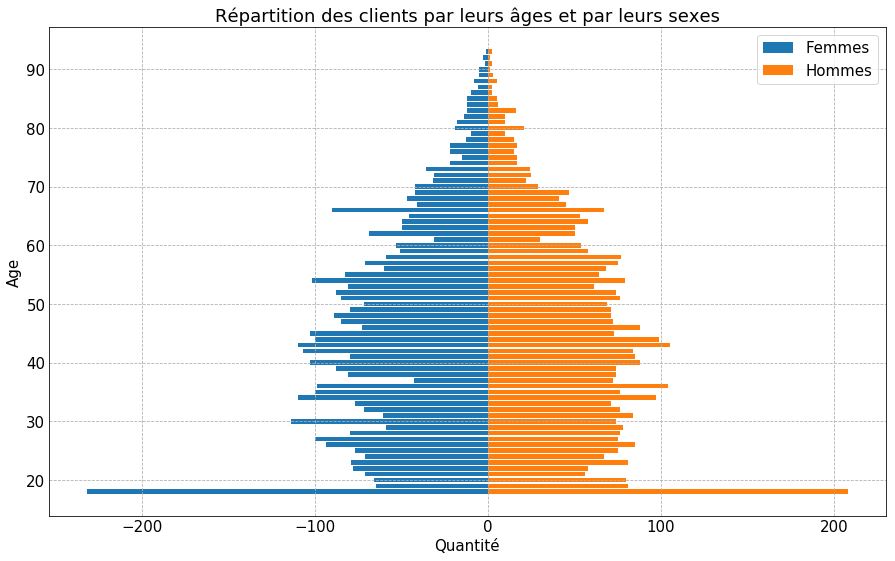

In [85]:
plt.figure(figsize = (15, 9))
femmes_nbre = -femmes_age['décompte femmes']
hommes_nbre = hommes_age['décompte hommes']
age = hommes_age.index
r = range(age.min(), len(age) + age.min())
plt.barh(r,
         femmes_nbre)
plt.barh(r,
         hommes_nbre)
plt.xlabel('Quantité',
           size = 15)
plt.ylabel('Age',
           size = 15)
plt.xticks()
plt.tick_params('both',
                length = 0)
plt.grid(linestyle = '--')
plt.legend(['Femmes', 'Hommes'])
plt.title('Répartition des clients par leurs âges et par leurs sexes', size = 18);

- On observe une répartition concernant l'effectif des 18 ans démesurément trop grande par rapport aux autres tranches d'âge des clients, expliquée certainement par des mineurs validant leurs achats en se faisant passer pour des majeurs de 18 ans.
- Pic à 66 ans: âge de départ à la retraite à taux plein.
- Profils assez symétriques dans l'ensemble.

In [86]:
# Dimension des 5 premiers effectifs:
clients_ok.age.value_counts().head()

18    440
43    215
34    207
36    203
44    199
Name: age, dtype: int64

A titre de comparaison, à la deuxième place, les 43 ans sont 215.<br/>
L'effectif des 18 ans est donc considérée comme valeur aberrante.<br/>On crée donc un dataset supplémentaire, utile possiblement pour des analyses futures qui nécessiteraient des effectifs non biaisés:

#### <span style='color:green'>Création d'un dataset dont l'effectif des 18 ans est supprimé:

In [87]:
clients_majeurs = clients_ok.drop(clients_ok.loc[clients_ok['age'] == 18].index, 0)
clients_majeurs.shape

(8181, 4)

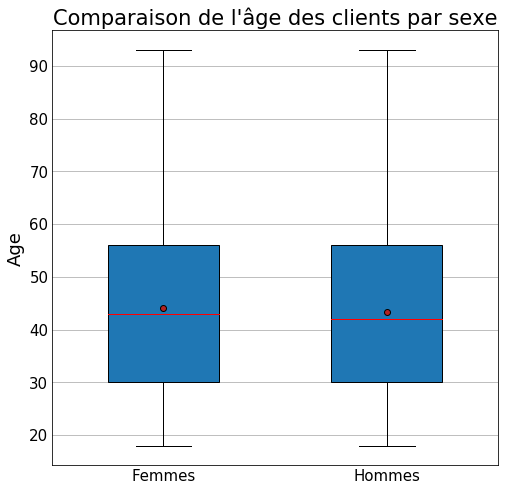

In [88]:
plt.figure(figsize = (8, 8))
ages = [femmes['age'],
        hommes['age']]
medianprops = {'color':"red"}
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}

plt.boxplot(ages,
            widths = 0.5,
            medianprops = medianprops,
            patch_artist = True,
            showmeans = True,
            meanprops = meanprops)
boites = ['Femmes',
          'Hommes']
plt.xticks([1,2],
           boites)
plt.tick_params(axis = 'both',
                length = 0)
plt.ylabel('Age',
           size = 18)
plt.grid(axis = 'y')
plt.title('Comparaison de l\'âge des clients par sexe',
          loc = 'center',
          size = 21);

- Quelque soit le sexe, aucun profil ne se distingue sensiblement de l'autre.
- La moitié des clients se situe entre 44 et 93 ans, sachant que le dernier quartile va de 56 ans à 93 ans.

## <span style='color:orange'>2. Que vend l'entreprise?<a name="M22"></a>

### <span style='color:purple'>a) Catégorie des produits proposés.<a name="M221"></a>

In [89]:
# Calcul des pourcentages:
proportion_0 = produits_ok['categ'].value_counts()[0]/produits_ok['categ'].value_counts().sum()*100
proportion_1 = produits_ok['categ'].value_counts()[1]/produits_ok['categ'].value_counts().sum()*100
proportion_2 = produits_ok['categ'].value_counts()[2]/produits_ok['categ'].value_counts().sum()*100

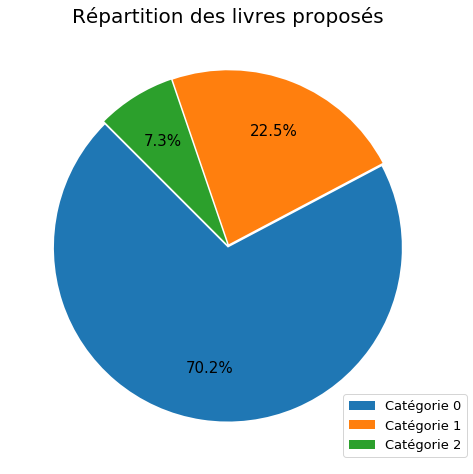

In [90]:
plt.figure(figsize = (8, 8))
plt.pie([proportion_0, proportion_1, proportion_2],
        autopct = '%.1f%%',
        explode = (0.01, 0.01, 0.01),
        pctdistance = 0.7,
        startangle = 135)
plt.legend(['Catégorie 0', 'Catégorie 1', 'Catégorie 2'],
           loc="lower left",
           prop = {'size' : 13},
           bbox_to_anchor=(0.75, 0, 1, 1))
plt.title('Répartition des livres proposés',
          size = 20);

Sur les 3286 livres disponibles à la vente, la catégorie 0 est majoritaire à 70%.

### <span style='color:purple'>b) Quels sont les prix des produits proposés?<a name="M222"></a>

In [91]:
produits_0 = produits_ok.loc[produits_ok['categ'] == 0]
produits_0.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
4,0_1507,3.99,0
5,0_1163,9.99,0


In [92]:
produits_0.price.median().round(2)

10.32

In [93]:
produits_1 = produits_ok.loc[produits_ok['categ'] == 1]

In [94]:
produits_2 = produits_ok.loc[produits_ok['categ'] == 2]

In [95]:
bins_0 = int(round(produits_0.price.max()/((produits_0.price.max() - produits_0.price.min())/len(produits_0)**(0.5)), 0))
bins_0

49

In [96]:
bins_1 = int(round(produits_1.price.max()/((produits_1.price.max() - produits_1.price.min())/len(produits_1)**(0.5)), 0))
bins_1

28

In [97]:
bins_2 = int(round(produits_2.price.max()/((produits_2.price.max() - produits_2.price.min())/len(produits_2)**(0.5)), 0))
bins_2

17

In [ ]:
plt.figure(figsize = (17, 9))

plt.subplot(311)
plt.hist([produits_0.price], bins = bins_0, edgecolor = 'w')
plt.axvline(x = produits_0.price.median().round(2), color = 'red')
plt.tick_params(axis = 'both', length = 0)
plt.legend(['Médiane', 'Catégorie 0'], fontsize = 12)

plt.subplot(312)
plt.hist([produits_1.price], bins = bins_1, color = 'darkorange', edgecolor = 'w')
plt.axvline(x = produits_1.price.median().round(2), color = 'red')
plt.ylabel('Volumes des produits', size = 15)
plt.tick_params(axis = 'both', length = 0)
plt.legend(['Médiane', 'Catégorie 1'], fontsize = 12)

plt.subplot(313)
plt.hist([produits_2.price], bins = bins_2, color = 'forestgreen', edgecolor = 'w')
plt.axvline(x = produits_2.price.median().round(2), color = 'red')
plt.xlabel('Prix (€)', size = 15)
plt.tick_params(axis = 'both', length = 0)
plt.tick_params(axis = 'both', length = 0)
plt.legend(['Médiane', 'Catégorie 2'], fontsize = 12)

plt.suptitle('Répartition des livres par prix');

- Catégories 0 et 1: La moitié des livres ont un prix de vente abordable.
- Catégorie 2: Il faut avoir un budget plus conséquent pour accéder à cette gamme => seuil psychologique à dépasser pour le client.

#### <span style='color:green'>Comparaison globale:<a name="M2221"></a>

In [ ]:
plt.figure(figsize = (15, 8))

prix = [produits_0['price'],
        produits_1['price'],
        produits_2['price']]

medianprops = {'color':"red"}
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}

plt.subplot(121)
plt.boxplot(prix, widths = 0.7, medianprops = medianprops,
            patch_artist = True,
            showmeans = True,
            meanprops = meanprops)
boites = ['0', '1', '2']
plt.xticks([1,2,3],
           boites)
plt.tick_params(axis = 'both',
                length = 0)
plt.xlabel('Catégories',
           size = 17)
plt.ylabel('Prix',
           size = 17)
plt.grid(axis = 'y')

plt.subplot(122)
plt.boxplot(prix,
            whis = 'range', # intégre les outliers
            widths = 0.7,
            medianprops = medianprops,
            patch_artist = True,
            showmeans = True,
            meanprops = meanprops)  
boites = ['0', '1', '2']
plt.xticks([1,2,3],
           boites)
plt.tick_params(axis = 'both',
                length = 0)
plt.xlabel('Catégories',
           size = 17)
plt.grid(axis = 'y')
plt.title('outliers intégrés',
          size = 19)

plt.suptitle('Comparaison des prix par catégorie', size = 19);

CCL: On intégre les outliers car ils font sens dans l'étude des prix de chaque catégorie.

In [ ]:
# Création d'une fonction qui permet de détailler les outliers:
def outliers(data, col):
    quartile_1 = data[col].quantile(0.25)
    quartile_3 = data[col].quantile(0.75)
    IQ = quartile_3 - quartile_1
    seuil = 1.5*IQ 
    print('Limite basse=',quartile_1 - seuil)
    print('Limite haute=',quartile_3 + seuil)
    aberrants = data[~data[col].between((quartile_1 - seuil), (quartile_3 + seuil))]
    sans_aberrants = data[data[col].between((quartile_1 - seuil), (quartile_3 + seuil))]
    print('Nombre d\'outliers:',aberrants.shape[0])
    return aberrants

In [ ]:
outliers(produits_0, 'price')

In [ ]:
outliers(produits_1, 'price')

In [ ]:
outliers(produits_2, 'price')

## <span style='color:orange'>3. Résultats bruts des ventes.<a name="M23"></a>

### <span style='color:purple'>a) Quels produits ont été vendus?<a name="M231"></a>

#### <span style='color:blue'>Volumes d'achat des produits:<a name="M2311"></a>

In [ ]:
activites.price = activites.price.apply(np.float64)

In [ ]:
vca_produits = pd.pivot_table(activites, 'client_id', ['id_prod', 'categ', 'price'], aggfunc = {'client_id': len})
vca_produits.reset_index(['categ', 'price'], inplace = True)
vca_produits.columns = ['categ', 'price', 'volume d\'achat'] 
vca_produits['montant'] = vca_produits.price.mul(vca_produits['volume d\'achat'], 0)
vca_produits.head()

In [ ]:
vca_produits0 = vca_produits[vca_produits.categ == 0]
vca_produits1 = vca_produits[vca_produits.categ == 1]
vca_produits2 = vca_produits[vca_produits.categ == 2]

#### <span style='color:green'>Podium des 10 livres de chaque catégorie les plus vendus:<a name="M23111"></a>

Catégorie 0:

In [ ]:
vca_produits0.sort_values(by = 'volume d\'achat', ascending = False).head(10)

Catégorie 1:

In [ ]:
vca_produits1.sort_values(by = 'volume d\'achat', ascending = False).head(10)

Catégorie 2:

In [ ]:
vca_produits2.sort_values(by = 'volume d\'achat', ascending = False).head(10)

In [ ]:
vca_produits0.count()[0]

In [ ]:
vca_produits0['volume d\'achat'].sum()

In [ ]:
vca_produits1.count()[0]

In [ ]:
vca_produits1['volume d\'achat'].sum()

In [ ]:
vca_produits2.count()[0]

In [ ]:
vca_produits2['volume d\'achat'].sum()

Quelques chiffres très généraux:<br/>
- 2292 livres catégorie 0:
                
     - 209529 ventes


- 737 livres catégorie 1:

     - 109735 ventes


- 236 livres catégorie 2:

     - 17552 ventes.

#### <span style='color:green'>Evolution du montant des ventes en fonction du volume de produits proposés:<a name="M23112"></a>

In [ ]:
fig = plt.figure(figsize = (8, 8))

ca_pro = vca_produits['montant'].values
lorenz = np.cumsum(np.sort(ca_pro)) / ca_pro.sum()
lorenz = np.append([0], lorenz)
x = np.linspace(0, 1, len(lorenz))

plt.plot(x, lorenz)
plt.plot(x, x)
plt.axhline(0.2, color = 'slateblue', linestyle = '--')
plt.legend(['Lorenz', 'D: y = x', 'Pareto'], loc = 'best', prop = {'size' : 12})
plt.grid()
plt.xlabel('Produits', size = 17)
plt.ylabel('Montant',  size = 17)
plt.tick_params(axis = 'both', length = 0, labelsize = 15)
plt.title('Evolution du montant des ventes', size = 20);

In [ ]:
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/len(ca_pro)
S = 0.5 - AUC
gini = 2*S
gini

L'indice de Gini confirme que le montant des ventes de livres est inégalitaire de l'ordre de 74%.<br/>Comme l'indique le principe de Pareto, 20% des livres vendus apportent 80 % du CA ce qui pose la question de:
- l'intêret de proposer autant de choix.
- ne cibler les ventes exclusivement que sur ses articles très prisés.
- les produits qui fonctionnent dans le temps.
- ceux qui ne fonctionnent pas ou plus.

#### <span style='color:blue'>Détail du volume des ventes par mois:<a name="M2312"></a>

In [ ]:
# table pivot affichant par mois les volumes et CA des ventes par catégorie et total
vca = activites.pivot_table('price' , 'annee-mois', 'categ', aggfunc = {'price': [len, np.sum]}, fill_value = 0)
vca['quantité totale'] = vca.len[0].add(vca.len[1]).add(vca.len[2])
vca['montant total'] = vca['sum'][0].add(vca['sum'][1]).add(vca['sum'][2])
vca.insert(6, 'montant total', vca.pop('montant total')) # Déplacement de la colonne créée.
vca.insert(3, 'quantité totale', vca.pop('quantité totale')) 
vca

In [ ]:
vca['montant total'].sum().astype(int)

Le montant du CA global est de l'ordre de 5 800 000 euros.

In [ ]:
qtt_c0 = vca.xs(0, axis = 1, level = 1).drop('sum', 1)
qtt_c0.head()

In [ ]:
quantite_c0 = qtt_c0.len

In [ ]:
qtt_c1 = vca.xs(1, axis = 1, level = 1).drop('sum', 1)
quantite_c1 = qtt_c1.len

In [ ]:
qtt_c2 = vca.xs(2, axis = 1, level = 1).drop('sum', 1)
quantite_c2 = qtt_c2.len

In [ ]:
plt.figure(figsize = (17, 9))

mois = vca.index

plt.plot(range(len(mois)),
        qtt_c0,
        'o-')
plt.plot(range(len(mois)),
        qtt_c1,
        'o-')
plt.plot(range(len(mois)),
        qtt_c2,
        'o-')
plt.xlabel('Mois',
           size = 21)
plt.tick_params(axis = 'both',
                length = 0,
               labelsize = 15)
plt.ylabel('Volume',
           size = 18)
plt.xticks(range(len(mois)),
           ['Mars', '', 'Mai', '', 'Jui', '', 'Sept','', 'Nov', '', 'Jan'])
plt.grid(axis = 'x')
plt.title('Volume de ventes par mois',
         size = 22)
plt.legend(['Catégorie 0', 'Catégorie 1', 'Catégorie 2'],
           fontsize = 13);

- La catégorie 2 étant relativement stable dans son évolution, on observe une compensation qui s'opère d'elle-même entre les ventes des catégories 0 et 1, ce qui permet de maintenir une stabilité continue des ventes.
- Nécessité d'avoir du personnel de ventes en septembre (rentrée littéraire) et pour Noël.
- Problème à éclaircir en octobre pour la catégorie 1.

#### <span style='color:green'>Recherche d'explications concernant la baisse soudaine d'octobre de la catégorie 1:<a name="M23121"></a>

In [ ]:
octobre = pd.pivot_table(activites[activites.categ == 1].loc[activites['annee-mois'] == '2021-10'], 'price', 'jour', aggfunc = {'price': sum})
octobre

In [ ]:
# On complète les jours manquants d'octobre afin de créer une table entière:
data = pd.DataFrame(index = range(2, 28), columns = ['price']).fillna(0)
data['jour'] = data.apply(lambda x: x.index)
octobre = octobre.reset_index()
octobre.jour = octobre['jour'].apply(lambda x: int(x))
octobre = pd.concat([octobre, data], sort = True)
octobre.sort_values(by = 'jour')
octobre = pd.pivot_table(octobre, 'price', 'jour')
octobre.reset_index(inplace = True)
octobre.head()

In [ ]:
plt.figure(figsize = (17, 8))
jour = []
for i in range(16):
    jour.append(2*i + 1)
    jour.append('')
plt.plot(range(len(octobre.index)),
        octobre.price,
        'red')
plt.xlabel('Jour',
           size = 21)
plt.ylabel('CA',
           fontsize=20)  
plt.grid(ls = '--')
plt.xticks(np.arange(len(octobre.index)),
           jour)
plt.tick_params(axis = 'both',
                length = 0,
               labelsize = 15)
plt.title('CA catégorie 1 en octobre',
          size = 23);

On constate qu'il n'y a eu aucune vente d'enregistrées entre le 2 et le 27 inclus.<br/>
Il y a donc certainement eu un problème technique de la part du serveur.
A signaler.

#### <span style='color:blue'>Détail du chiffre d'affaires par mois:<a name="M2313"></a>

In [ ]:
ca_c0 = vca.xs(0, axis = 1, level = 1).drop('len', 1)
ca_c0 = ca_c0.reset_index()
ca_c0.head()

In [ ]:
ca_c1 = vca.xs(1, axis = 1, level = 1).drop('len', 1)
ca_c1 = ca_c1.reset_index()

In [ ]:
ca_c2 = vca.xs(2, axis = 1, level = 1).drop('len', 1)
ca_c2 = ca_c2.reset_index()

In [ ]:
ca = vca.xs('montant total', axis = 1, level = 0)
ca = ca.reset_index()
ca.columns = ['annee-mois', 'montant total']

In [ ]:
plt.figure(figsize = (17, 9))
mois = ca.index
plt.bar(range(len(mois)),
        ca_c0['sum'],
        bottom = ca_c1['sum'] + ca_c2['sum'],
        edgecolor = 'w',
        linewidth = 2)
plt.bar(range(len(mois)),
        ca_c1['sum'],
        bottom = ca_c2['sum'],
        edgecolor = 'w',
        linewidth = 2)
plt.bar(range(len(mois)),
        ca_c2['sum'],
        edgecolor = 'w',
        linewidth = 2)
plt.axhline(ca['montant total'].mean(),
          color = 'r')
plt.xticks(np.arange(len(mois)),
           ['Mars', '', 'Mai', '', 'Jui', '', 'Sept','', 'Nov', '', 'Jan'])
plt.tick_params(axis = 'both',
                length = 0,
               labelsize = 15)
plt.ylabel('CA',
           size = 21)
plt.legend(['Moyenne', 'Catégorie 0', 'Catégorie 1', 'Catégorie 2'],
           loc= (0.87, 1.02),
           prop = {'size' : 12})
for x,y in zip(range(len(mois)), ca['montant total'].astype(int)):
    plt.text(x,
             y,
             y,
             ha = 'center', 
             va = 'bottom',
             fontsize = 15)
plt.title('CA par mois',
          size = 23);

CCL:
A part une baisse importante enregistrée en octobre due à une panne de serveur, le CA ne fait qu\'augmenter.

In [ ]:
qtt_tot = vca.xs('quantité totale', axis = 1, level = 0)
qtt_tot.reset_index(inplace = True)
qtt_tot.sum(1)

In [ ]:
plt.figure(figsize = (17, 9))
mois = ca.index
ax1 = plt.subplot()
ax1.plot(range(len(mois)),
        ca.sum(1),
        'bo-')
plt.xlabel('Mois',
           size = 21)
plt.ylabel('CA',
           color = 'b',
           fontsize = 20)  
for tl in ax1.get_yticklabels(): tl.set_color('b')
plt.legend(['CA'])
plt.tick_params(axis = 'both',
                length = 0,
               labelsize = 15)

ax2 = ax1.twinx()
ax2.plot(range(len(mois)),
        qtt_tot.sum(1),
        'ro-')
plt.ylabel('Ventes',
           color='r',
           fontsize=20)  
for tl in ax2.get_yticklabels(): tl.set_color('r')
plt.legend(['Ventes'],
          loc = 'center right')

plt.xticks(np.arange(len(mois)),
           ['Mars', '', 'Mai', '', 'Jui', '', 'Sept','', 'Nov', '', 'Jan'],
          size = 20)
plt.tick_params(axis = 'both',
                length = 0,
               labelsize = 15)
plt.grid(ls = '--')
plt.title('CA global et ventes',
          size = 23);

CCL:
- Les ventes en moins des livres de catégorie 1 en octobre (10000 ventes en moins) font s'effondrer le CA global.
Cette catégorie joue donc un rôle prépondérant dans la santé financière de l'entreprise.
- Malgré cela, quand les ventes diminuent, le CA reste stable ou continue de croître.

#### <span style='color:blue'>Comparaison chiffre d'affaire et volume des ventes:<a name="M2314"></a>

In [ ]:
# Calcul des proportions des CA et des ventes par catégorie:
prop_ca_c0 = vca['sum'].sum()[0]/vca['montant total'].sum()*100
prop_ca_c1 = vca['sum'].sum()[1]/vca['montant total'].sum()*100
prop_ca_c2 = vca['sum'].sum()[2]/vca['montant total'].sum()*100
prop_v0 = quantite_c0.sum()/vca.sum()[0]*100
prop_v1 = quantite_c1.sum()/vca.sum()[0]*100
prop_v2 = quantite_c2.sum()/vca.sum()[0]*100

In [ ]:
plt.figure(figsize = (15, 8))
plt.subplot(1, 2, 1)
plt.pie([prop_v0, prop_v1, prop_v2],
        autopct = '%.1f%%',
        explode = (0.01, 0.01, 0.01),
        pctdistance = 0.7,
        startangle = 135)
plt.legend(['Catégorie 0', 'Catégorie 1', 'Catégorie 2'],
           loc="lower left",
           prop = {'size' : 13},
           bbox_to_anchor=(0.95, 0, 1, 1))
plt.title('Ventes',
          size = 20)

plt.subplot(1, 2, 2)
plt.pie([prop_ca_c0, prop_ca_c1, prop_ca_c2],
        autopct = '%.1f%%',
        explode = (0.01, 0.01, 0.01),
        pctdistance = 0.5,
        startangle = 135)
plt.title('CA',
          size = 20)
plt.suptitle('Ventes et CA global de l\'entreprise',
             size = 21);

- Très bonne équilibre des ventes en général.
- La catégorie 1 domine le CA.
- La catégorie 2 ne représente que 5% des ventes: Malgré cela, son CA est équivalent à quasiment un quart des ventes, ce qui montre son importance dans la santé financière de l'entreprise.

### <span style='color:purple'>b) Composition du panier des clients:<a name="M232"></a>

In [ ]:
paniers = activites.pivot_table('price' , 'client_id', 'categ', aggfunc = {'price': [len, np.sum]}, fill_value = 0)
paniers['quantité totale'] = paniers.len[0].add(paniers.len[1]).add(paniers.len[2])
paniers['montant total'] = paniers['sum'][0].add(paniers['sum'][1]).add(paniers['sum'][2])
paniers.insert(6, 'montant total', paniers.pop('montant total'))
paniers.insert(3, 'quantité totale', paniers.pop('quantité totale'))
paniers.sort_values('montant total', ascending = False).head()

On remarque 4 clients dont les achats sont des outliers.<br/>
Ces clients sont des revendeurs professionnels qui se fournissent par le biais de l\'entreprise.

In [ ]:
fig = plt.figure(figsize = (8, 8))

paniers_totaux = paniers['montant total'].values
lorenz_total= np.cumsum(np.sort(paniers_totaux)) / paniers_totaux.sum()
lorenz_total = np.append([0], lorenz_total)
x_total = np.linspace(0, 1, len(lorenz_total))

paniers_qc = paniers[paniers['montant total'] < 50000]
paniers_lambda = paniers_qc['montant total'].values
lorenz_lambda = np.cumsum(np.sort(paniers_lambda)) / paniers_lambda.sum()
lorenz_lambda = np.append([0], lorenz_lambda)
x_lambda = np.linspace(0, 1, len(lorenz_lambda))

plt.plot(x_total,
         lorenz_total,
         color = 'blue')
plt.plot(x_lambda,
         lorenz_lambda,
         color = 'indigo')
plt.plot(x_total,
         x_total,
         color = 'red')
plt.axhline(0.5,
            color = 'slateblue',
            linestyle = '--')
plt.xlabel('Nombre de clients (en %)',
          size = 18)
plt.ylabel('Chiffres d\'affaires (en %)',
          size = 18)
plt.legend(['Tout client', 'Clients lambda', 'D: y = x', 'médiale'],
           loc= 'lower right',
           prop = {'size' : 12})
plt.grid()
plt.tick_params(axis = 'both',
                length = 0,
               labelsize = 15)
plt.title('Achats tout clients vs clients lambda',
         size = 22);

Les 4 revendeurs professionnels génèrent 7.5 % du CA global sur les plus de 8600 acheteurs.

In [ ]:
AUC = (lorenz_total.sum() -lorenz_total[-1]/2 -lorenz_total[0]/2)/len(paniers_totaux)
S = 0.5 - AUC
gini_total = 2*S
gini_total

In [ ]:
AUC = (lorenz_lambda.sum() -lorenz_lambda[-1]/2 -lorenz_lambda[0]/2)/len(paniers_lambda)
S = 0.5 - AUC
gini_lambda = 2*S
gini_lambda

Les indices de Gini confirment le "déséquilibre" causé par ces seuls quatre revendeurs. 

#### <span style='color:blue'>Paniers revendeurs et paniers clients lambda<a name="M2321"></a>

On sépare les revendeurs des clients lambda pour les besoins de l'analyse.
<br/>On étudiera ici principalement les habitudes de consommation des clients lambda, celles des revendeurs (si on peut employer en ce qui les concerne le terme "habitude") n'étant pas ici ce qui nous intéresse de prime abord.
<br/>Elles pourront faire l'objet d'une analyse ultérieure.

In [ ]:
paniers_pro = paniers.sort_values('montant total', ascending = False).iloc[0:4]
paniers_pro # OK pour eux.

In [ ]:
paniers_lambda = paniers.sort_values('montant total', ascending = False).iloc[4::]
paniers_lambda.head(10) # Ok pour tous les autres

In [ ]:
paniers_pro.describe().round(0).astype(int)

In [ ]:
paniers_lambda.describe().astype(int)

Les descriptions des paniers des vendeurs professionnels et des clients lambda sont radicalement différentes.  

In [ ]:
# Calcul des propotions de CA par catégorie pour les revendeurs et les clients lambda:

prop_cac0_pro = paniers_pro['sum'].sum()[0]/paniers_pro['montant total'].sum()*100
prop_cac1_pro = paniers_pro['sum'].sum()[1]/paniers_pro['montant total'].sum()*100
prop_cac2_pro = paniers_pro['sum'].sum()[2]/paniers_pro['montant total'].sum()*100

prop_cac0_lambda = paniers_lambda['sum'].sum()[0]/paniers_lambda['montant total'].sum()*100
prop_cac1_lambda = paniers_lambda['sum'].sum()[1]/paniers_lambda['montant total'].sum()*100
prop_cac2_lambda = paniers_lambda['sum'].sum()[2]/paniers_lambda['montant total'].sum()*100

In [ ]:
# # Calcul des proportions de volume de ventes par catégorie pour les revendeurs et les clients lambda:

prop_v0_pro = paniers_pro['len'].sum()[0]/paniers_pro.sum()[0]*100
prop_v1_pro = paniers_pro['len'].sum()[1]/paniers_pro.sum()[0]*100
prop_v2_pro = paniers_pro['len'].sum()[2]/paniers_pro.sum()[0]*100

prop_v0_lambda = paniers_lambda['len'].sum()[0]/paniers_lambda.sum()[0]*100
prop_v1_lambda = paniers_lambda['len'].sum()[1]/paniers_lambda.sum()[0]*100
prop_v2_lambda = paniers_lambda['len'].sum()[2]/paniers_lambda.sum()[0]*100

In [ ]:
plt.figure(figsize = (15, 9))

plt.subplot(2, 2, 1)
plt.pie([prop_v0_pro, prop_v1_pro, prop_v2_pro],
        autopct = '%.1f%%',
        explode = (0.01, 0.01, 0.01),
        pctdistance = 0.7,
        startangle = 135)
plt.title('Ventes revendeurs',
          size = 18)

plt.subplot(2, 2, 3)
plt.pie([prop_cac0_pro, prop_cac1_pro, prop_cac2_pro],
        autopct = '%.1f%%',
        explode = (0.01, 0.01, 0.01),
        pctdistance = 0.5,
        startangle = 135)
plt.title('CA revendeurs',
          size = 18)

plt.subplot(2, 2, 2)
plt.pie([prop_v0_lambda, prop_v1_lambda, prop_v2_lambda],
        autopct = '%.1f%%',
        explode = (0.01, 0.01, 0.01),
        pctdistance = 0.8,
        startangle = 135)
plt.title('Ventes clients lambda',
          size = 18)
plt.legend(['Catégorie 0', 'Catégorie 1', 'Catégorie 2'],
           loc="lower left",
           prop = {'size' : 12},
           bbox_to_anchor= (-0.7, -0.2, 1, 1))

plt.subplot(2, 2, 4)
plt.pie([prop_cac0_lambda, prop_cac1_lambda, prop_cac2_lambda],
        autopct = '%.1f%%',
        explode = (0.01, 0.01, 0.01),
        pctdistance = 0.7,
        startangle = 135)
plt.title('CA clients lambda',
          size = 18)

plt.suptitle('Vente et CA revendeurs et clients lambda',
            size = 20);

CCL:<br/>
Le bilan de l'entreprise suit les mêmes tendances que celui des revendeurs.<br/>
Le CA catégorie 2 apporté par les revendeurs contribue de manière non négligeable à la santé financière de l'entreprise.

#### <span style='color:blue'>Comparaison montant et nombre d'articles des paniers clients lambda:<a name="M2322"></a>

In [ ]:
paniers_ca = paniers_lambda.xs('montant total', axis = 1, level = 0, drop_level = False)
paniers_ca.reset_index(inplace = True)
paniers_ca.columns = ['client_id', 'montant total']
paniers_ca.sort_values('montant total', ascending = False).head(10)

In [ ]:
bins_ca = int(round(paniers_ca['montant total'].max()/((paniers_ca['montant total'].max() - paniers_ca['montant total'].min())/len(paniers_ca)**(0.5)), 0))
bins_ca

In [ ]:
paniers_v = paniers_lambda.xs('quantité totale', axis = 1, level = 0, drop_level = False)
paniers_v.reset_index(inplace = True)
paniers_v.columns = ['client_id', 'quantité totale']
paniers_v.sort_values('quantité totale', ascending = False).head(10)

In [ ]:
bins_v = int(round(paniers_v['quantité totale'].max()/((paniers_v['quantité totale'].max() - paniers_v['quantité totale'].min())/len(paniers_v)**(0.5)), 0))
bins_v

In [ ]:
plt.figure(figsize = (17, 9))

plt.subplot(2,1,1)
plt.hist(paniers_ca['montant total'],
         bins = bins_ca,
         color = 'gold',
         edgecolor = 'black')
plt.xlabel('Montant',
           size = 17)
plt.ylabel('Nombre de clients',
           size = 15)
plt.tick_params(axis = 'both',
                length = 0,
               labelsize = 15)
plt.axvline(x = paniers_ca['montant total'].median(),
            color = 'blue',
            linewidth = 3)
plt.legend(['Médiane'],
           fontsize = 15)
plt.title('Paniers des clients lambda', size = 22)

plt.subplot(2,1,2)
plt.hist(paniers_v['quantité totale'],
         bins = bins_v,
         color = 'gold',
         edgecolor = 'black')
plt.xlabel('Nombre d\'articles',
           size = 17)
plt.ylabel('Nombre de clients',
           size = 15)
plt.tick_params(axis = 'both',
                length = 0,
               labelsize = 15)
plt.axvline(x = paniers_v['quantité totale'].median(),
            color = 'blue',
            linewidth = 3)
plt.legend(['Médiane'],
           fontsize = 15);

### <span style='color:purple'>4. Sexe des clients par catégorie de produits achetés:<a name="M24"></a>

Le choix est fait ici de ne travailler qu'avec les achats des clients lambdas, afin de préserver une analyse réaliste des ventes.<br/>
Il faut donc séparer les achats réalisées par les revendeurs de ceux des clients lambdas:

In [ ]:
# Les identifiants des 4 revendeurs:
liste_revendeurs = list(paniers.sort_values('montant total', ascending = False).index[:4]) 
liste_revendeurs

In [ ]:
# Création d'une table contenant uniquement les achats des revendeurs:
activites_pro = pd.DataFrame(columns = ['session_id', 'annee-mois', 'jour', 'heure-min', 'id_prod', 'price', 'categ', 'client_id', 'sex', 'age', 'birth'])
for x in liste_revendeurs:
    activites_pro = activites_pro.append(activites[activites.client_id == x])
activites_pro.head()

In [ ]:
# On retire les achats des revendeurs de la table activites:
activites_lambda = activites.drop(activites_pro.index, 0)
# C'est cette table qui nous intéresse pour la suite!

In [ ]:
activites_lambda.shape

In [ ]:
activites_lambda.price = activites_lambda.price.apply(np.float64)

#### <span style='color:blue'>Analyse <a name="M241"></a>

In [ ]:
sexe = activites_lambda.pivot_table('price', 'sex', 'categ', aggfunc = {'price': [len, np.sum]}, fill_value = 0)
sexe['quantité totale'] = sexe.len[0].add(sexe.len[1]).add(sexe.len[2])
sexe['montant total'] = sexe['sum'][0].add(sexe['sum'][1]).add(sexe['sum'][2])
sexe.insert(6, 'montant total', sexe.pop('montant total'))
sexe.insert(3, 'quantité totale', sexe.pop('quantité totale'))
sexe.sort_values('montant total', ascending = False)

In [ ]:
# Pourcentage d'achats et de CA pour chaque sexe toutes catégorie:
f_v = sexe.xs('f', axis = 0)[:4] / sexe.xs('f', axis = 0)[3] * 100
h_v = sexe.xs('m', axis = 0)[:4] / sexe.xs('f', axis = 0)[3] * 100
f_ca = sexe.xs('f', axis = 0)[4:] / sexe.xs('f', axis = 0)[7] * 100
h_ca = sexe.xs('m', axis = 0)[4:] / sexe.xs('f', axis = 0)[7] * 100

In [ ]:
plt.figure(figsize = (15, 9))

plt.subplot(2, 2, 1)
plt.pie([f_v[0], f_v[1], f_v[2]],
        autopct = '%.1f%%',
        explode = (0.01, 0.01, 0.01),
        pctdistance = 0.8,
        startangle = 135)
plt.title('Ventes femmes',
          size = 18)

plt.subplot(2, 2, 3)
plt.pie([f_ca[0], f_ca[1], f_ca[2]],
        autopct = '%.1f%%',
        explode = (0.01, 0.01, 0.01),
        pctdistance = 0.7,
        startangle = 135)
plt.title('CA femmes',
          size = 18)

plt.subplot(2, 2, 2)
plt.pie([h_v[0], h_v[1], h_v[2]],
        autopct = '%.1f%%',
        explode = (0.01, 0.01, 0.01),
        pctdistance = 0.8,
        startangle = 135)
plt.title('Ventes hommes',
          size = 18)
plt.legend(['Catégorie 0', 'Catégorie 1', 'Catégorie 2'],
           loc="lower left",
           prop = {'size' : 12},
           bbox_to_anchor= (-0.7, -0.2, 1, 1))

plt.subplot(2, 2, 4)
plt.pie([h_ca[0], h_ca[1], h_ca[2]],
        autopct = '%.1f%%',
        explode = (0.01, 0.01, 0.01),
        pctdistance = 0.7,
        startangle = 135)
plt.title('CA hommes',
          size = 18)

plt.suptitle('Ventes et CA pour chaque sexe des clients lambda',
            size = 20);

In [ ]:
# Pourcentage d'achats et de CA entre chaque sexe dans la catégorie 0:
f_v0 = sexe.xs('f', axis = 0)[0] / (sexe.xs('f', axis = 0)[0] + sexe.xs('m', axis = 0)[0]) * 100
h_v0 = sexe.xs('m', axis = 0)[0] / (sexe.xs('f', axis = 0)[0] + sexe.xs('m', axis = 0)[0]) * 100
f_ca0 = sexe.xs('f', axis = 0)[4] / (sexe.xs('f', axis = 0)[4] + sexe.xs('m', axis = 0)[4]) * 100
h_ca0 = sexe.xs('m', axis = 0)[4] / (sexe.xs('f', axis = 0)[4] + sexe.xs('m', axis = 0)[4]) * 100

In [ ]:
# Pourcentage d'achats et de CA entre chaque sexe dans la catégorie 1:
f_v1 = sexe.xs('f', axis = 0)[1] / (sexe.xs('f', axis = 0)[1] + sexe.xs('m', axis = 0)[1]) * 100
h_v1 = sexe.xs('m', axis = 0)[1] / (sexe.xs('f', axis = 0)[1] + sexe.xs('m', axis = 0)[1]) * 100
f_ca1 = sexe.xs('f', axis = 0)[5] / (sexe.xs('f', axis = 0)[5] + sexe.xs('m', axis = 0)[5]) * 100
h_ca1 = sexe.xs('m', axis = 0)[5] / (sexe.xs('f', axis = 0)[5] + sexe.xs('m', axis = 0)[5]) * 100

In [ ]:
# Pourcentage d'achats et de CA entre chaque sexe dans la catégorie 2:
f_v2 = sexe.xs('f', axis = 0)[2] / (sexe.xs('f', axis = 0)[2] + sexe.xs('m', axis = 0)[2]) * 100
h_v2 = sexe.xs('m', axis = 0)[2] / (sexe.xs('f', axis = 0)[2] + sexe.xs('m', axis = 0)[2]) * 100
f_ca2 = sexe.xs('f', axis = 0)[6] / (sexe.xs('f', axis = 0)[6] + sexe.xs('m', axis = 0)[6]) * 100
h_ca2 = sexe.xs('m', axis = 0)[6] / (sexe.xs('f', axis = 0)[6] + sexe.xs('m', axis = 0)[6]) * 100

In [ ]:
plt.figure(figsize = (17, 8))

barWidth = 0.3
r1 = range(3)
r2 = [x + barWidth for x in r1]
r3 = range(3,6)
r4 = [x + barWidth for x in r3]

plt.bar(r1,
        [f_v0, f_v1, f_v2],
        width = barWidth,
        linewidth = 2,
        color = 'tomato',
        edgecolor = 'w')
plt.bar(r2,
        [h_v0, h_v1, h_v2],
        width = barWidth,
        linewidth = 2,
        color = 'darkslateblue',
        edgecolor = 'w')
plt.bar(r3,
        [f_ca0, f_ca1, f_ca2],
        width = barWidth,
        linewidth = 2,
        color = 'brown',
        edgecolor = 'w')
plt.bar(r4,
        [h_ca0, h_ca1, h_ca2],
        width = barWidth,
        linewidth = 2,
        color = 'midnightblue',
        edgecolor = 'w')
plt.tick_params(axis = 'both',
                length = 0,
               labelsize = 15)
plt.ylabel('Quantité (%)',
           size = 18)
plt.xticks([x + barWidth / 2 for x in range(6)],
           ['Ventes\nCatégorie 0', 'Ventes\nCatégorie 1', 'Ventes\nCatégorie 2', 'CA\nCatégorie 0', 'CA\nCatégorie 1', 'CA\nCatégorie 2'])
plt.title('Comparaison ventes et CA par sexe des clients lambda',
         size = 22)
plt.legend(['Femmes', 'Hommes', 'Femmes', 'Hommes'],
           loc = 'lower right',
           fontsize = 13);

CCL: Il semble y avoir corrélation entre le sexe des clients et les catégories de produits achetés.

#### <span style='color:blue'>Corrélation (variables qualitatives)<a name="M242"></a>

On fait l'hypothèse nulle qu'il y a indépendance entre les deux variables.

In [ ]:
# Création de la matrice "valeurs observées" (tableau de contingence):
X = 'sex'
Y = 'categ'
cont = activites_lambda[[X,Y]].pivot_table(index = 'sex', columns = 'categ', aggfunc = len).fillna(0)
contingence = cont.copy()

tx = activites_lambda['sex'].value_counts()
ty = activites_lambda['categ'].value_counts()

contingence.loc[:, 'Total'] = tx
contingence.loc['total', :] = ty
contingence.loc['total', 'Total'] = len(activites_lambda)
contingence.astype(int)

In [ ]:
# Création de la matrice "valeurs attendues" (tableau d'indépendance):
tx_df = pd.DataFrame(tx)
tx_df.columns = ["c"]
ty_df = pd.DataFrame(ty)
ty_df.columns = ["c"]

n = len(activites_lambda)

independance = pd.DataFrame(np.dot(tx_df, ty_df.T) / n, index = ['f', 'm'], columns = [0, 1, 2]).astype(int)
independance

In [ ]:
# Calcul de la matrice "écart au carré normalisé de la valeur attendue VS valeur observée":
frequence = (cont - independance)**2/independance
frequence

In [ ]:
# Calcul du khi²:
# Somme des valeurs de la précédente matrice. Cette somme suit une loi du Chi2 à k degrés de liberté.
xi_n = frequence.sum().sum()
xi_n

In [ ]:
# Calcul du degré de liberté dl:
# dl = (nbre de lignes de la table de contingence - 1) x (nbre de colonnes - 1)  
# NB: les lignes et colonnes des totaux ne sont pas pris en compte.
dl = (2 - 1) * (3 - 1)
dl

D'après la table du khi², avec un degré de liberté valant 2, notre khi² est supérieur à la valeur théorique du khi² (environ 9,2) pour un risque de 1% mais inférieur à la valeur théorique du khi² (environ 10,5) pour un risque de 0.5%.<br/>Avec un risque de 1% (ce qui est plus que suffisant), on peut donc rejeter l'hypothèse d'indépendance entre les deux variables.


Confirmation par la carte de chaleur:

In [ ]:
table = frequence / xi_n
table

In [ ]:
sns.heatmap(table, annot = table, lw = 1);

Les deux cases de la catégorie 1 participent à hauteur d'environ 33% à la valeur du Khi².<br/>
Or la différence de ses deux valeurs est un delta plus important que celui de l'ensemble des catégories.<br/>
Notre Khi² étant significatif, on peut conclure qu'il y a donc bien corrélation entre le sexe des clients et les catégories de produits achetés bien qu'étant assez "faible", elle soit donc difficilement exploitable commercialement parlant!

Vérification avec la librairie Scipy.stats:

In [ ]:
# Calcul du khi2 et de la pvalue à partir de la matrice des valeurs observées:
st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)

In [ ]:
st_exp # C'est bien la même matrice qui représentait le tableau d'indépendance.

In [ ]:
st_dof # Nombre de degré de liberté k

In [ ]:
st_chi2 # On retrouve quasiment la même valeur calculée manuellement.

In [ ]:
st_p # p-value empirique

La p-value est inférieur à 1 %, on peut donc rejeter avec un risque d'erreur inférieur à 1% l'hypothèse nulle disant que les deux variables sont indépendantes.

### <span style='color:purple'>5. Age des clients... <a name="M25"></a>

### <span style='color:purple'>a) ...  et montant total des achats<a name="M251"></a>

##### <span style='color:blue'>Analyse<a name="M2511"></a>

Regardons d'un point de vue global l'évolution du montant total par tranches d'âge (donc sans différencier chaque client):

In [ ]:
montant = pd.pivot_table(activites_lambda, 'price', 'age', 'categ', aggfunc = np.sum, fill_value = 0)
montant['montant total'] = montant.sum(1)

montant.head()

In [ ]:
plt.figure(figsize = (17, 10))

age = []
for i in range(len(montant.index)):
    age.append(montant.index.min() + 3*i)
    age.append('')
    age.append('')
    
plt.bar(range(len(montant.index)),
        montant['montant total'])

plt.xticks(np.arange(len(montant.index)),
           age,
          fontsize = 13)
plt.tick_params(axis = 'both',
                length = 0,
               labelsize = 15)
plt.ylabel('Montant total',
           size = 19)
plt.yticks(size = 15)
plt.title('Montant total des ventes en fonction de l\'âge',
          size = 22);

En dehors du pic attendu des 18 ans, il semble y avoir deux tendances.<br/>Analysons maintenant le montant total de chaque client.

##### <span style='color:blue'>Corrélation (variables quantitatives):<a name="M2512"></a>

In [ ]:
obs = pd.pivot_table(activites_lambda, 'price', ['age', 'client_id'], aggfunc = np.sum, fill_value = 0)
obs.columns = ['montant']
obs.reset_index(inplace = True)
obs.drop('client_id', 1, inplace = True)
obs.head()

In [ ]:
plt.figure(figsize = (17, 8))

plt.scatter(obs.age, obs.montant)

X1 = obs['age'].iloc[:obs[obs['montant'] == obs['montant'].max()].index.item()]
Y1 = obs['montant'].iloc[:obs[obs['montant'] == obs['montant'].max()].index.item()]
X1 = X1[:, np.newaxis]
Y1 = Y1[:, np.newaxis]  # incrémente la dimension du tableau existant et transforme en vecteur colonne
model1 = linear_model.LinearRegression()
model1.fit(X1, Y1) # ajuste le modèle
print(model1.coef_, model1.intercept_)
X_NEW1 = np.linspace(obs['age'].min(),
                     obs[obs['montant'] == obs['montant'].max()]['age'].item(), # obtenir l'âge correspondant au montant max
                     100)
X_NEW1 = X_NEW1[:, np.newaxis]
Y_NEW1 = model1.predict(X_NEW1)
plt.plot(X_NEW1,
         Y_NEW1,
         color = 'black',
         linewidth = 3)

X2 = obs['age'].iloc[obs[obs['montant'] == obs['montant'].max()].index.item():]
Y2 = obs['montant'].iloc[obs[obs['montant'] == obs['montant'].max()].index.item():]
X2 = X2[:, np.newaxis]
Y2 = Y2[:, np.newaxis]
model2 = linear_model.LinearRegression()
model2.fit(X2, Y2)
print(model2.coef_, model2.intercept_)
X_NEW2 = np.linspace(obs[obs['montant'] == obs['montant'].max()]['age'].item(),
                     obs['age'].max(),
                     100)
X_NEW2 = X_NEW2[:, np.newaxis]
Y_NEW2 = model2.predict(X_NEW2)
plt.plot(X_NEW2,
         Y_NEW2, 
         color = 'red',
         linewidth = 3)

plt.xlabel('Age',
           size = 17)
plt.ylabel('Montant',
           size = 17)
plt.tick_params(axis = 'both',
                length = 0,
                labelsize = 15)
plt.grid()
plt.title('Montant des achats par âge',
             fontsize = 21);

In [ ]:
# Coefficent de détermination R² sur la 1ère catégorie d'âge:
model1.score(X1,Y1)

In [ ]:
# Coefficent de détermination R² sur la 2ème catégorie d'âge:
model2.score(X2,Y2)

CCL: Le modèle explique peu la distribution des points dans les 2 catégories d'âge.

In [ ]:
# Coefficient de corrélation de Pearson pour la 1ère catégorie d'âge:
st.pearsonr(obs['age'].iloc[:obs[obs['montant'] == obs['montant'].max()].index.item()], obs['montant'].iloc[:obs[obs['montant'] == obs['montant'].max()].index.item()])

In [ ]:
# Coefficient de corrélation de Pearson pour la 2ème catégorie d'âge:
st.pearsonr(obs['age'].iloc[obs[obs['montant'] == obs['montant'].max()].index.item():], obs['montant'].iloc[obs[obs['montant'] == obs['montant'].max()].index.item():])

CCL: On ne peut pas conclure sur la linéarité des variables pour les 2 catégories d'âge.

In [ ]:
# ANOVA:
# Moyenne des montants d'achat de la 1ère catégorie d'âge:
m1 = obs.montant.iloc[:obs[obs.montant == obs.montant.max()].index.item()].mean()
# Moyenne des montants d'achat de la 2ème catégorie d'âge:
m2 = obs.montant.iloc[obs[obs.montant == obs.montant.max()].index.item():].mean()
# Moyenne globale des montants d'achat:
m = obs.montant.mean()
# Variation interclasse:
SCE = obs.montant.iloc[:obs[obs.montant == obs.montant.max()].index.item()].shape[0]*(m1 - m)**2 + obs.montant.iloc[obs[obs.montant == obs.montant.max()].index.item():].shape[0]*(m2 - m)**2

In [ ]:
# variance interclasse estimée:
k = 2
MCE = SCE / (k - 1)

In [ ]:
# Variation intraclasse:
erreur1 = list(obs.montant.iloc[:obs[obs.montant == obs.montant.max()].index.item()] - m1)
erreur2 = list(obs.montant.iloc[obs[obs.montant == obs.montant.max()].index.item():] - m2)
erreur = erreur1 + erreur2
scr = []
for err in erreur:
    scr.append(err**2)
SCR = np.sum(scr)

In [ ]:
# Degré de liberté:
dl = len(obs) - k

In [ ]:
# Variance intraclasse estimée:
MCR = SCR / dl

In [ ]:
# Vérification des calculs:
F = MCE / MCR
F

In [ ]:
st.f_oneway(obs.montant.iloc[:obs[obs.montant == obs.montant.max()].index.item()], obs.montant.iloc[obs[obs.montant == obs.montant.max()].index.item():])
# Ok !

In [ ]:
# Variation totale:
SCT = np.sum((obs.montant - m)**2)

In [ ]:
# Calcul de eta²:
eta_2 = SCE / SCT
eta_2

Les règles générales données par Cohen et Miles & Shevlin (2001) pour analyser eta_2, c'est-à-dire l'effet taille (ou comment la variance est expliquée) énoncent:
- effet petit: 0.01
- effet moyen: 0.06
- effet grand: 0.14

Le modèle de régression linéaire explique la variance à hauteur de 6 % ce qui représente un effet taille moyen.
<br/>Le test est donc moyennement significatif.

CCL: On ne peut donc pas vraiment conclure sur la corrélation entre l'âge des clients et le montant total.
<br/>Les clients, passés 50 ans, commencent à simplement dépenser un peu moins.

### <span style='color:purple'>b) ...  et fréquence d'achat par mois<a name="M252"></a>

##### <span style='color:blue'>Analyse<a name="M2531"></a>

In [ ]:
freq = pd.pivot_table(activites_lambda, 'price', index = ['age', 'client_id', 'session_id'], aggfunc = len, fill_value = 0)
freq = freq.groupby(['age','client_id']).count()
freq.reset_index(inplace = True)
freq.drop('client_id', 1, inplace = True)
freq.columns = ['age', 'nbre_session']
freq['fréquence moyenne d\'achat par mois'] = round(freq.nbre_session/12, 2)
freq.head()

In [ ]:
plt.figure(figsize = (10, 9))
nombre = [freq['fréquence moyenne d\'achat par mois'].loc[freq.age <= 30],
        freq['fréquence moyenne d\'achat par mois'].loc[freq.age >=31]]

medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
  
plt.boxplot(nombre,
            widths = 0.5,
            patch_artist = True,
            medianprops = medianprops,
            showmeans = True,
            meanprops = meanprops)
boites = ['18-30 ans', '31 ans et plus']
plt.xticks([1,2],
           boites)
plt.tick_params(axis = 'both',
                length = 0)
plt.ylabel('Fréquence',
           size = 17)
plt.grid(axis = 'y')
plt.title('Fréquence mensuelle d\'achat d\'articles par catégorie d\'âge',
          size = 19);

##### <span style='color:blue'>Corrélation (variable qualitative et quantitative)<a name="M2532"></a>

In [ ]:
plt.figure(figsize = (17, 9))

plt.scatter(freq.age, freq['fréquence moyenne d\'achat par mois'])

X1 = freq.age[freq.age <= 30]
Y1 = freq['fréquence moyenne d\'achat par mois'].loc[freq.age <= 30]
X1 = X1[:, np.newaxis]
Y1 = Y1[:, np.newaxis]

model1 = linear_model.LinearRegression()
model1.fit(X1, Y1)
print(model1.coef_, model1.intercept_)
X_NEW1 = np.linspace(X1.min(),
                     X1.max(),
                     100)
X_NEW1 = X_NEW1[:, np.newaxis]
Y_NEW1 = model1.predict(X_NEW1)
plt.plot(X_NEW1,
         Y_NEW1,
         color = 'indigo',
         linewidth = 5)

X2 = freq.age[freq.age >= 31]
Y2 = freq['fréquence moyenne d\'achat par mois'].loc[freq.age >= 31]
X2 = X2[:, np.newaxis]
Y2 = Y2[:, np.newaxis]
model2 = linear_model.LinearRegression()
model2.fit(X2, Y2)
print(model2.coef_, model2.intercept_)
X_NEW2 = np.linspace(X2.min(),
                     X2.max(),
                     100)
X_NEW2 = X_NEW2[:, np.newaxis]
Y_NEW2 = model2.predict(X_NEW2)
plt.plot(X_NEW2,
         Y_NEW2, 
         color = 'black',
         linewidth = 5)

plt.xlabel('Age',
           size = 18)
plt.ylabel('Fréquence',
           size = 18)
plt.tick_params(axis = 'both',
                length = 0)
plt.grid()
plt.title('Fréquence mensuelle d\'achat par rapport à l\'âge',
          size = 22);

In [ ]:
# ANOVA:
# Moyenne des fréquences mensuelle d'achat moyennes de la 1ère catégorie d'âge:
m1 = freq['fréquence moyenne d\'achat par mois'][freq.age <= 30].mean()
# Moyenne des fréquences mensuelle d'achat moyennes de la 2ème catégorie d'âge:
m2 = freq['fréquence moyenne d\'achat par mois'][freq.age > 30].mean()
# Moyenne globale des fréquence mensuelle d'achat moyennes:
m = freq['fréquence moyenne d\'achat par mois'].mean()
# Variation interclasse:
SCE = freq['fréquence moyenne d\'achat par mois'][freq.age <= 30].shape[0]*(m1 - m)**2 + freq['fréquence moyenne d\'achat par mois'][freq.age > 30].shape[0]*(m2 - m)**2

In [ ]:
st.f_oneway(freq['fréquence moyenne d\'achat par mois'][freq.age <= 30], freq['fréquence moyenne d\'achat par mois'][freq.age > 30])

In [ ]:
# Variation totale:
SCT = np.sum((freq['fréquence moyenne d\'achat par mois'] - m)**2)

In [ ]:
# Calcul de eta²:
eta_2 = SCE / SCT
eta_2

Le rapport de corrélation nous indique que la variation est expliquée par le modèle de régression à hauteur de 13 %.<br/>
Au regar de la p_value, le test est relativement significatif.<br/>
Il y a bien corrélation de manière générale entre l'âge et la fréquence d'achat mensuelle.

### <span style='color:purple'>c) ... et taille du panier moyen en nombre d'articles<a name="M253"></a>

##### <span style='color:blue'>Analyse<a name="M2531"></a>

In [ ]:
paniers_age = pd.pivot_table(activites_lambda, 'price', ['age', 'client_id'], 'annee-mois', aggfunc = len, fill_value = 0)
paniers_age['moyenne'] = round(paniers_age.sum(1)/12, 2)
paniers_age.reset_index(inplace = True)
paniers_age.drop(['client_id', '2021-03', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01','2022-02'], 1, inplace = True)
paniers_age.columns = ['age', 'panier_moyen']
paniers_age.head()

In [ ]:
plt.figure(figsize = (10, 9))

medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}

taille = [paniers_age.panier_moyen.loc[paniers_age.age <= 30],
        paniers_age.panier_moyen.loc[paniers_age.age <=50].loc[paniers_age.age >=31],
        paniers_age.panier_moyen.loc[paniers_age.age >= 51]]
plt.boxplot(taille,
            widths = 0.7,
            patch_artist = True,
            medianprops = medianprops,
            showmeans = True,
            meanprops = meanprops)
boites = ['18-30 ans', '31-50 ans', 'plus de 51 ans']
plt.xticks([1,2,3],
           boites)
plt.tick_params(axis = 'both',
                length = 0)
plt.ylabel('Fréquence',
           size = 17)
plt.grid(axis = 'y')
plt.title('Taille du panier moyen en nombre d\'articles par catégorie d\'âge',
          size = 19);

##### <span style='color:blue'>Corrélation (variable qualitative et quantitative)<a name="M2542"></a>

In [ ]:
plt.figure(figsize = (17, 9))

plt.scatter(paniers_age.age, paniers_age.panier_moyen)

X1 = paniers_age.age[paniers_age.age <= 30]
Y1 = paniers_age.panier_moyen[paniers_age.age <= 30]
X1 = X1[:, np.newaxis]
Y1 = Y1[:, np.newaxis]

X2 = paniers_age.age[paniers_age.age >= 31][paniers_age.age <= 50] 
Y2 = paniers_age.panier_moyen[paniers_age.age >= 31][paniers_age.age <= 50]
X2 = X2[:, np.newaxis]
Y2 = Y2[:, np.newaxis]

X3 = paniers_age.age[paniers_age.age >= 51]
Y3 = paniers_age.panier_moyen[paniers_age.age >= 51]
X3 = X3[:, np.newaxis]
Y3 = Y3[:, np.newaxis]

model1 = linear_model.LinearRegression()
model1.fit(X1, Y1)
print(model1.coef_, model1.intercept_)

model2 = linear_model.LinearRegression()
model2.fit(X2, Y2)
print(model2.coef_, model2.intercept_)

model3 = linear_model.LinearRegression()
model3.fit(X3, Y3)
print(model3.coef_, model3.intercept_)

X_NEW1 = np.linspace(X1.min(),
                     X1.max(),
                     100)
X_NEW1 = X_NEW1[:, np.newaxis]
Y_NEW1 = model1.predict(X_NEW1)

X_NEW2 = np.linspace(X2.min(),
                     X2.max(),
                     100)
X_NEW2 = X_NEW2[:, np.newaxis]
Y_NEW2 = model2.predict(X_NEW2)

X_NEW3 = np.linspace(X3.min(),
                     X3.max(),
                     100)
X_NEW3 = X_NEW3[:, np.newaxis]
Y_NEW3 = model3.predict(X_NEW3)

plt.plot(X_NEW1,
         Y_NEW1,
         color = 'indigo',
         linewidth = 5)
plt.plot(X_NEW2,
         Y_NEW2, 
         color = 'black',
         linewidth = 5)
plt.plot(X_NEW3,
         Y_NEW3, 
         color = 'darkblue',
         linewidth = 5)

plt.xlabel('Age',
           size = 18)
plt.ylabel('Panier',
           size = 18)
plt.tick_params(axis = 'both',
                length = 0)
plt.grid()
plt.title('Panier moyen en nombre d\'articles par rapport à l\'âge',
          size = 22);

In [ ]:
# ANOVA:
# Moyenne des paniers moyens annuels de la 1ère catégorie d'âge:
m1 = paniers_age.panier_moyen[paniers_age.age <= 30].mean()
# Moyenne des paniers moyens annuels de la 2ème catégorie d'âge:
m2 = paniers_age.panier_moyen[paniers_age.age <=50][paniers_age.age >=31].mean()
# Moyenne des paniers moyens annuels de la 3ème catégorie d'âge:
m3 = paniers_age.panier_moyen[paniers_age.age >= 51].mean()
# Moyenne globale des paniers moyens annuels:
m = paniers_age.panier_moyen.mean()
# Variation interclasse:
SCE = paniers_age.panier_moyen[paniers_age.age <= 30].shape[0]*(m1 - m)**2 + paniers_age.panier_moyen[paniers_age.age <=50][paniers_age.age >=31].shape[0]*(m2 - m)**2 + paniers_age.panier_moyen[paniers_age.age >= 51].shape[0]*(m3 - m)**2

In [ ]:
st.f_oneway(paniers_age.panier_moyen[paniers_age.age <= 30], paniers_age.panier_moyen[paniers_age.age <=50][paniers_age.age >=31], paniers_age.panier_moyen[paniers_age.age >= 51])

In [ ]:
# Variation totale:
SCT = np.sum((paniers_age.panier_moyen - m)**2)

In [ ]:
# Calcul de eta²:
eta_2 = SCE / SCT
eta_2

CCL:<br/>
Le rapport de corrélation explique bien la variation autour des moyennes à hauteur de 29%.
Au regard de la p_value, le test est donc significatif.<br/>
Il y a bien une corrélation entre l'âge des clients et le panier moyen annuel.<br/>
Cependant, les clients ont des paniers significativement différent selon les catégories d'âge.<br/>
Il faut donc repenser le ciblage marketing par ces tranches d'âge. 

### <span style='color:purple'>d) ... et catégories de produits achetés<a name="M254"></a>

##### <span style='color:blue'>Analyse<a name="M2541"></a>

In [ ]:
ages = pd.pivot_table(activites_lambda, 'price', 'age', 'categ', aggfunc = len, fill_value = 0)
ages['quantité totale'] = ages.sum(1)
ages.reset_index(inplace = True)
ages.columns = ['age', '0', '1', '2', 'quantité totale']
ages.set_index('age').head()

In [ ]:
plt.figure(figsize = (17, 10))

age = []
for i in range(len(ages)):
    age.append(ages.age.min() + 3*i)
    age.append('')
    age.append('')
    
plt.bar(range(len(ages)),
        ages['0'],
        bottom = ages['1'] + ages['2'],
        edgecolor = 'w')
plt.bar(range(len(ages)),
        ages['1'],
        bottom = ages['2'],
        edgecolor = 'w')
plt.bar(range(len(ages)),
        ages['2'],
        edgecolor = 'w')


plt.xticks(np.arange(len(ages)),
           age,
          fontsize = 13)
plt.tick_params(axis = 'both',
                length = 0,
               labelsize = 15)
plt.ylabel('Volumes',
           size = 19)
plt.yticks(size = 15)
plt.legend(['Catégorie 0', 'Catégorie 1', 'Catégorie 2'])
plt.title('Comparaison de ventes en fonction de l\'âge',
          size = 22);

CCL:
- Il semble y avoir corrélation de l'âge avec les catégories de produits achetés.
- On remarque des catégories beaucoup plus achetées que d'autres par certaines tranches d'âge (ce qui peut être intéressant soit à exploiter commercialement, soit à compenser dans les autres catégories d'âge).

##### <span style='color:blue'>Corrélation<a name="M2542"></a>

Ici, on considère que les variables sont qualitatives.

ERREUR: on ne peut pas considérer l'âge comme tel car laissé ainsi, il est nécessairemnt quantitatif. Il faut indispensablement le convertir en catégorie afin de pouvoir le considérer qualitatif.

On fait l'hypothèse nulle que les variables sont indépendantes.

In [ ]:
# Création de la matrice "valeurs observées" (tableau de contingence):
X = 'age'
Y = 'categ'
cont2 = activites_lambda[[X,Y]].pivot_table(index = 'age', columns = 'categ', aggfunc = len).fillna(0)
contingence2 = cont2.copy()

tx2 = activites_lambda['age'].value_counts()
ty2 = activites_lambda['categ'].value_counts()

contingence2.loc[:, 'Total'] = tx2
contingence2.loc['total', :] = ty2
contingence2.loc['total', 'Total'] = len(activites_lambda)
contingence2.astype(int).head()

In [ ]:
## Création de la matrice "valeurs attendues" (tableau d'indépendance):
tx2_df = pd.DataFrame(contingence2['Total'].iloc[:76])
tx2_df.columns = ["c"]
ty2_df = pd.DataFrame(contingence2.loc['total'].iloc[:3])
ty2_df.columns = ["c"]

n = len(activites_lambda)

independance2 = pd.DataFrame(np.dot(tx2_df, ty2_df.T) / n, index = list(cont2.index), columns = [0, 1, 2]).astype(int)
independance2.head()

In [ ]:
# Calcul de la matrice "écart au carré normalisé de la valeur attendue VS valeur observée":
frequence2 = (cont2 - independance2)**2/independance2
frequence2.head()

In [ ]:
# Calcul du khi²:
# Somme des valeurs de la précédente matrice. Cette somme suit une loi du khi² à k degrés de liberté.
xi_n = frequence2.sum().sum()
xi_n

In [ ]:
# Calcul du degré de liberté dl:
# dl = (nbre de lignes de la table de contingence - 1) x (nbre de colonnes - 1)  
# Nota bene: les lignes et colonnes des totaux ne sont pas pris en compte.
dl = (76 - 1) * (3 - 1)
dl

D'après le tableau du khi², avec un degré de liberté de 150, notre khi² empirique est nettement supérieur au khi² théorique  même avec un risque d'erreur de 0.1% (autour de 210).<br/>
En conséquence, avec une fiabilité de plus de 99.9%, on peut affirmer que l'hypothèse d'indépendance est rejetée.
<br/>Il y a donc clairement corrélation entre les deux variables.

Confirmation par la carte de chaleur:

In [ ]:
table2 = frequence2 / xi_n
table2.head()

In [ ]:
plt.figure(figsize = (10, 20))
plt.title('Ventes',
         size = 22)
sns.heatmap(table2, annot = table2);

CCL:<br/>
Au regard de la p_value, notre test est significatif.<br/>
On observe très bien par la catégorie 2 les différences de couleurs qui indiquent qu'il y a bel et bien une relation de corréation entre l'âge des clients et les catégories de produits achetés.

Vérification par scikit-learn:

In [ ]:
st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont2)

In [ ]:
st_dof

In [ ]:
#st_exp

In [ ]:
st_chi2 # On retrouve quasiment la valeur trouvé "manuellement"

In [ ]:
st_p # confirme bien la corrélation des variables avec un risque d'erreur dérisoire.

Notre test est significatif.
<br/>Il y a donc bien corrélation des variables avec un risque d'erreur inférieur à 0.1%

Correctif: Traitement de variables de type qualitatif et quantitatif:

In [ ]:
activites_lambda.head()

In [ ]:
var0 = activites_lambda.age.loc[activites_lambda.categ == 0]
var1 = activites_lambda.age.loc[activites_lambda.categ == 1]
var2 = activites_lambda.age.loc[activites_lambda.categ == 2]

In [ ]:
plt.figure(figsize = (10, 9))

medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}

taille = [var0, var1, var2]
plt.boxplot(taille,
            showfliers = False,
            widths = 0.7,
            patch_artist = True,
            medianprops = medianprops,
            showmeans = True,
            meanprops = meanprops)
boites = ['0', '1', '2']
plt.xticks([1,2,3],
           boites)
plt.tick_params(axis = 'both',
                length = 0)
plt.ylabel('Age des clients',
           size = 17)
plt.grid(axis = 'y')

plt.title('Age des clients en fonction des catégories achetées',
          size = 22);

In [ ]:
# ANOVA:
# Moyenne des âges de la catégorie 0:
m0 = var0.mean()
# Moyenne des âges de la catégorie 1:
m1 = var1.mean()
# Moyenne des âges de la catégorie 2:
m2 = var2.mean()
# Moyenne globale des âges:
m = activites_lambda.age.mean()
# Variation interclasse:
SCE = var0.shape[0]*(m0 - m)**2 + var1.shape[0]*(m1 - m)**2 + var2.shape[0]*(m2 - m)**2
# Variation totale:
SCT = np.sum((activites_lambda.age - m)**2)
# Calcul de eta²:
eta_2 = SCE / SCT
eta_2

In [ ]:
st.f_oneway(var0, var1, var2)

Les variations sont expliquées autour de la moyenne à hauteur de 11% ce qui est un effet taille relativement grand.<br/>
Au regard de la p_value, le test est donc significatif.<br/>
Il y a donc corrélation entre l'âge des clients et les catégories de produits achetés.